In [50]:
import pandas as pd
import re
from PETRUS.g2p.g2p import G2PTranscriber
from PETRUS.stress.tonic import StressDetector
import matplotlib.pyplot as plt

In [51]:
def is_vowel(char):
    # Define a regex pattern for vowels including accented ones
    padrao = r'[aeiouáàâãäåéèêëíìîïóòôõöúùûüýÿ]'
    return bool(re.fullmatch(padrao, char, re.IGNORECASE))

def tem_acentos(palavra):
    # Regex para encontrar caracteres acentuados
    padrao = r'[áàâãäåéèêëíìîïóòôõöúùûüýÿ]'
    return bool(re.search(padrao, palavra))

def separate_syllables(word):
    syllables = G2PTranscriber(word, algorithm="ceci").get_syllables() 
    if 'i' in syllables:
        syllables = G2PTranscriber(word, algorithm="silva").get_syllables()
    return syllables


In [52]:
# Step 1: Read the words from the text file
with open('output/words.txt', 'r', encoding='utf-8') as file:
    words = file.read().splitlines()

words_by_syllables = [separate_syllables(word) for word in words]
stressed_syllables_positions = [StressDetector(word).get_stress_syllable(syllables) for word, syllables in zip(words, words_by_syllables)]
stressed_syllable_idxs = [len(syllables) - syllables.index(word[pos[0]:pos[1]]) for word, pos, syllables in zip(words, stressed_syllables_positions, words_by_syllables)]

# Step 2: Process each word to extract the necessary information
data = {
    'word': words,
    'syllables': [str(syllables) for syllables in words_by_syllables],
    'syllable_count': [len(syllables) for syllables in words_by_syllables],
    'last_syllable': [syllables[-1] for syllables in words_by_syllables],
    'stressed_syllable_idx': stressed_syllable_idxs,
    'stressed_syllable': [syllables[-stressed_idx] for syllables, stressed_idx in zip(words_by_syllables, stressed_syllable_idxs)],
    'first_letter': [word[0] if word else '' for word in words],
    'start_with_vowel': [is_vowel(word[0]) if word[0] != 'h' else is_vowel(word[1]) for word in words],
    'last_letter': [word[-1] if word else '' for word in words],
    'end_with_vowel': [is_vowel(word[-1]) for word in words]
}

# Step 3: Create a DataFrame with the processed data
df = pd.DataFrame(data)

mascara = ~df['word'].apply(tem_acentos) & (df['stressed_syllable_idx'] == 3)
df = df[~mascara]

df.to_csv('output/words.csv', index=False)
print("CSV file created successfully.")

CSV file created successfully.


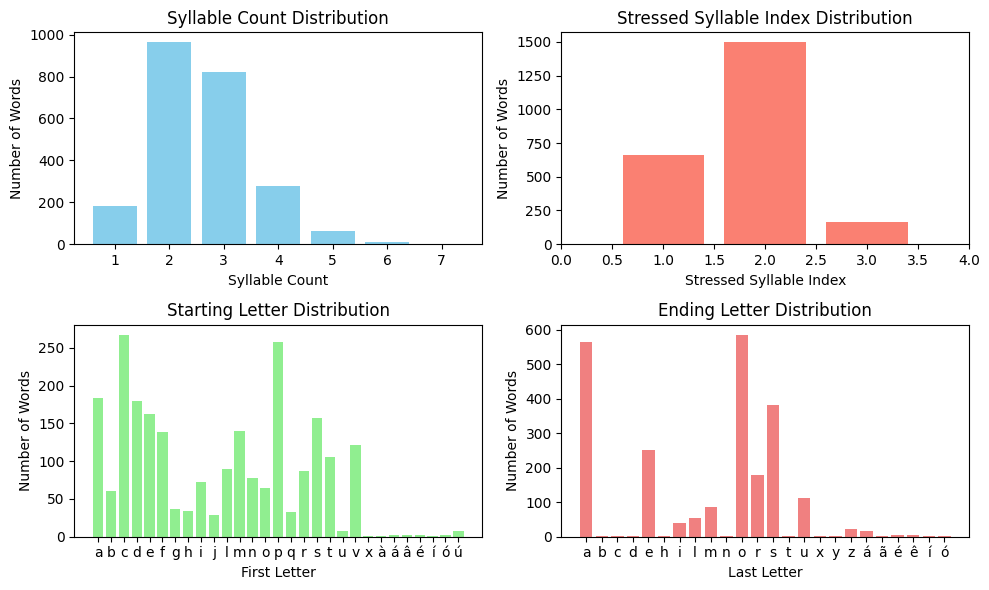

In [53]:
# Creating a 4 subplot plot
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot 1: Syllable Count Distribution
axs[0, 0].bar(df['syllable_count'].value_counts().sort_index().index, 
              df['syllable_count'].value_counts().sort_index().values, 
              color='skyblue')
axs[0, 0].set_title('Syllable Count Distribution')
axs[0, 0].set_xlabel('Syllable Count')
axs[0, 0].set_ylabel('Number of Words')
axs[0, 0].set_xticks([1, 2, 3, 4, 5, 6, 7])

# Plot 2: Stressed Syllable Index Distribution
axs[0, 1].bar(df['stressed_syllable_idx'].value_counts().sort_index().index, 
              df['stressed_syllable_idx'].value_counts().sort_index().values, 
              color='salmon')
axs[0, 1].set_title('Stressed Syllable Index Distribution')
axs[0, 1].set_xlabel('Stressed Syllable Index')
axs[0, 1].set_ylabel('Number of Words')
axs[0, 1].set_xlim([0, 4])

# Plot 3: Starting Letter Distribution
axs[1, 0].bar(df['first_letter'].value_counts().sort_index().index, 
              df['first_letter'].value_counts().sort_index().values, 
              color='lightgreen')
axs[1, 0].set_title('Starting Letter Distribution')
axs[1, 0].set_xlabel('First Letter')
axs[1, 0].set_ylabel('Number of Words')

# Plot 4: Ending Letter Distribution
axs[1, 1].bar(df['last_letter'].value_counts().sort_index().index, 
              df['last_letter'].value_counts().sort_index().values, 
              color='lightcoral')
axs[1, 1].set_title('Ending Letter Distribution')
axs[1, 1].set_xlabel('Last Letter')
axs[1, 1].set_ylabel('Number of Words')

# Adjust layout
plt.tight_layout()
plt.show()